# Zillow Clustering Project 

##### Imports:

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data Handling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

# Wrangle file to acquire and clean Zillow data
import wrangle_zillow as wr
import sklearn.preprocessing

# Explore file
import explore as ex
import explore_evaluate as ee
from sklearn.cluster import KMeans

# Models
import zillow_models as zm

## Acquire:

In [2]:
zillow = wr.wrangle_zillow()
zillow.head(3)

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet    fips    latitude  \
0          3.5         4.0                        3100.0  6059.0  33634931.0   
1          1.0         2.0                        1465.0  6111.0  34449266.0   
2          2.0         3.0                        1243.0  6059.0  33886168.0   

     longitude  yearbuilt  taxvaluedollarcnt  logerror transactiondate  \
0 -117869207.0     1998.0          1023282.0  0.025595      2017-01-01   
1 -119281531.0     1967.0           464000.0  0.055619      2017-01-01   
2 -117823170.0     1962.0           564778.0  0.005383      2017-01-01   

  heatingorsystemdesc   county  
0                None   Orange  
1                None  Ventura  
2                None   Orange

In [3]:
zillow['abs_logerr'] = zillow.logerror.apply(lambda x: x if x >= 0 else -x)
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70910 entries, 0 to 77380
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   70910 non-null  float64
 1   bedroomcnt                    70910 non-null  float64
 2   calculatedfinishedsquarefeet  70910 non-null  float64
 3   fips                          70910 non-null  float64
 4   latitude                      70910 non-null  float64
 5   longitude                     70910 non-null  float64
 6   yearbuilt                     70910 non-null  float64
 7   taxvaluedollarcnt             70910 non-null  float64
 8   logerror                      70910 non-null  float64
 9   transactiondate               70910 non-null  object 
 10  heatingorsystemdesc           70910 non-null  object 
 11  county                        70910 non-null  object 
 12  abs_logerr                    70910 non-null  float64
dtypes

### Train, Validate, Test Split

In [4]:
train, validate, test = wr.train_validate_test_split(zillow)
print("train observations: ", train.size)
print("validate observations: ", validate.size)
print("test observations: ", test.size)

train observations:  553098
validate observations:  184366
test observations:  184366


## Explore:

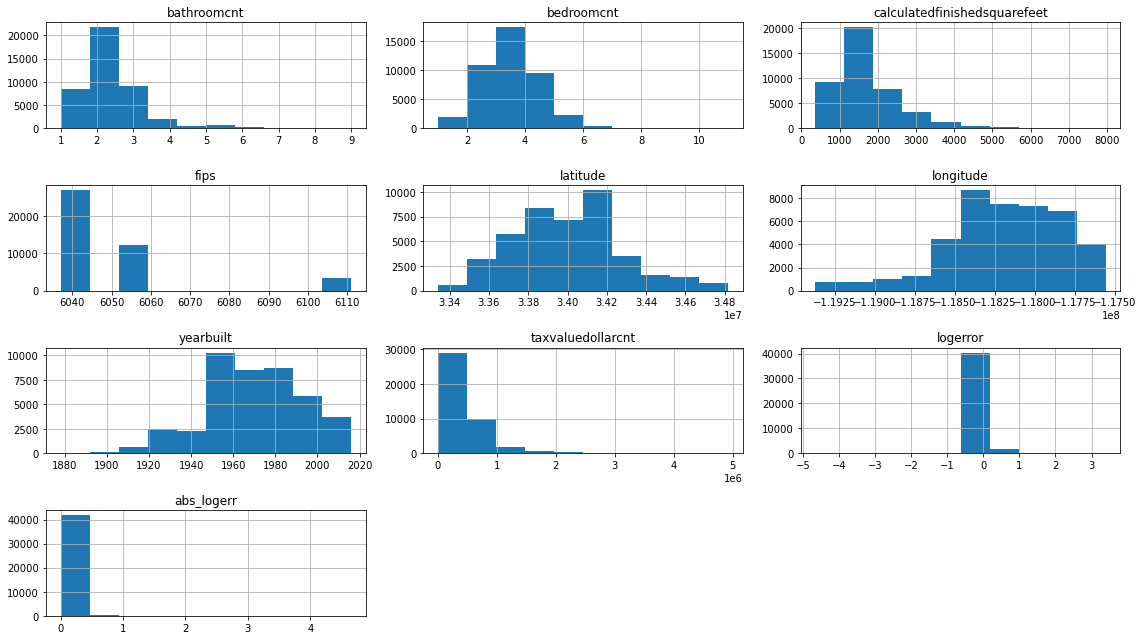

In [5]:
train.hist(figsize=(16,9))
plt.tight_layout()
plt.show()

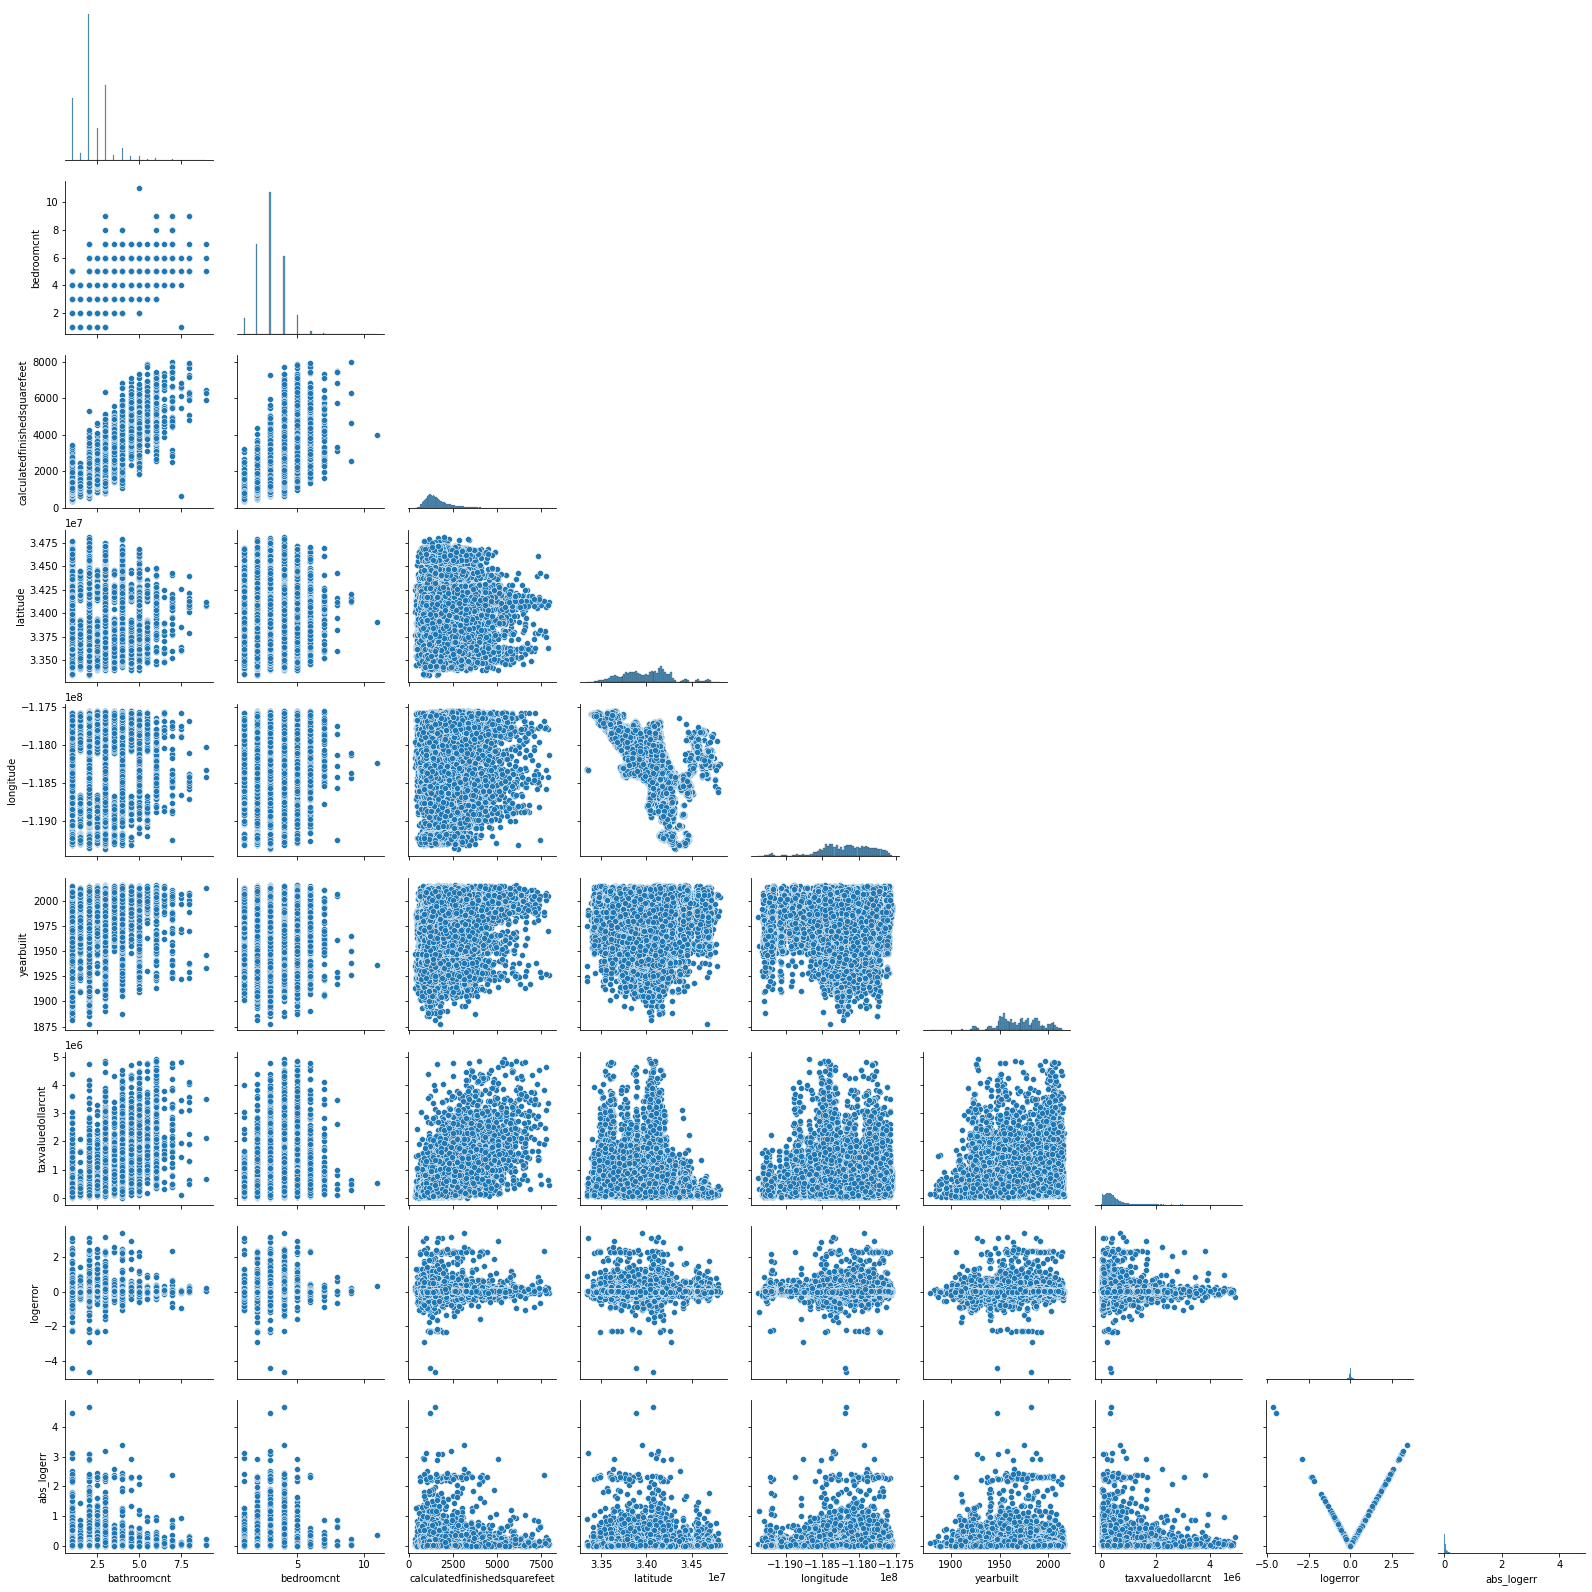

In [6]:
sns.pairplot(train.drop(columns='fips'), corner=True)
plt.show()

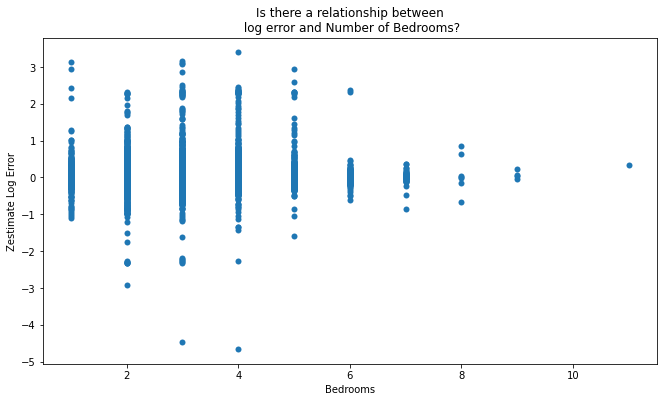

In [7]:
# Plot of log error vs number of bedrooms
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="bedroomcnt", y="logerror",
                sizes=(1, 8), linewidth=0,
                data=train, ax=ax)
plt.title('Is there a relationship between\n log error and Number of Bedrooms?')
plt.xlabel('Bedrooms')
plt.ylabel('Zestimate Log Error')
ax.xaxis.set_major_formatter('{:.0f}'.format)
plt.show()

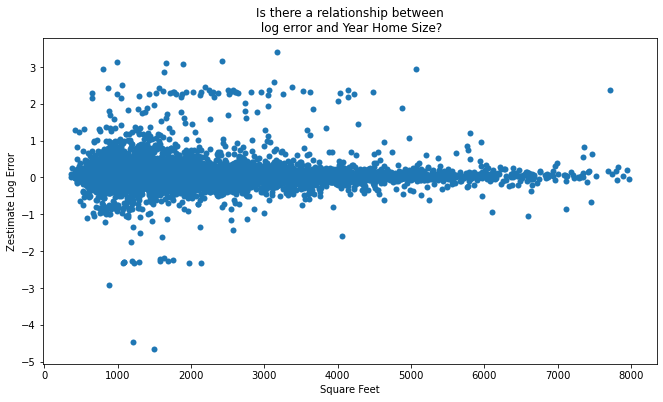

In [8]:
# Plot of log error vs square feet
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="calculatedfinishedsquarefeet", y="logerror",
                sizes=(1, 8), linewidth=0,
                data=train, ax=ax)
plt.title('Is there a relationship between\n log error and Year Home Size?')
plt.xlabel('Square Feet')
plt.ylabel('Zestimate Log Error')
ax.xaxis.set_major_formatter('{:.0f}'.format)
plt.show()

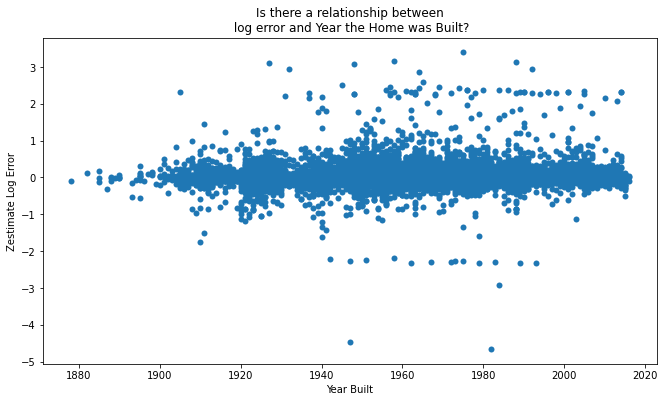

In [9]:
# Plot of log error vs year built
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="yearbuilt", y="logerror",
                sizes=(1, 8), linewidth=0,
                data=train, ax=ax)
plt.title('Is there a relationship between\n log error and Year the Home was Built?')
plt.xlabel('Year Built')
plt.ylabel('Zestimate Log Error')
ax.xaxis.set_major_formatter('{:.0f}'.format)
plt.show()

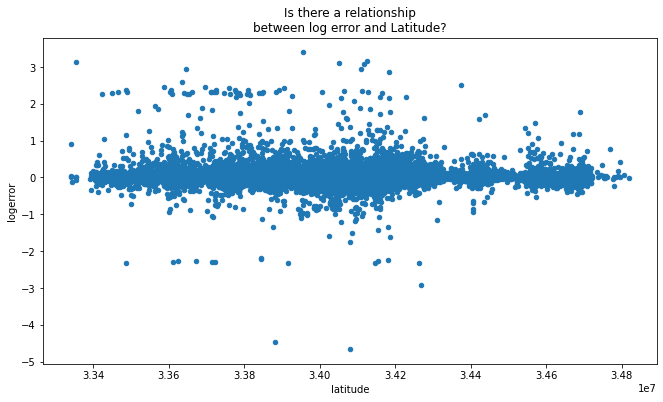

In [10]:
train.plot.scatter(
    x="latitude",
    y="logerror",
    title='Is there a relationship\nbetween log error and Latitude?',
    figsize=(11, 6)
)
plt.show()

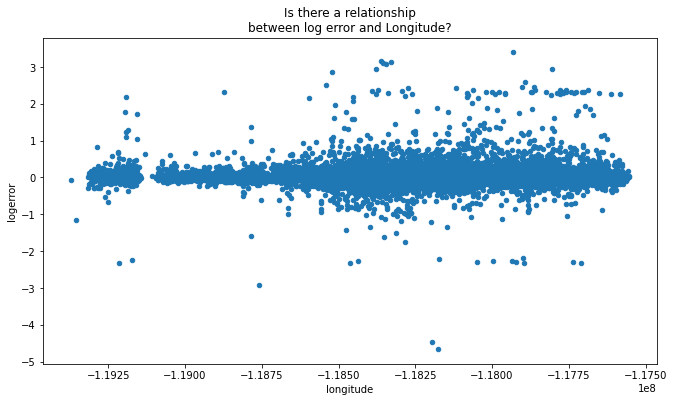

In [11]:
train.plot.scatter(
    x="longitude",
    y="logerror",
    title='Is there a relationship\nbetween log error and Longitude?',
    figsize=(11, 6),
)
plt.show()

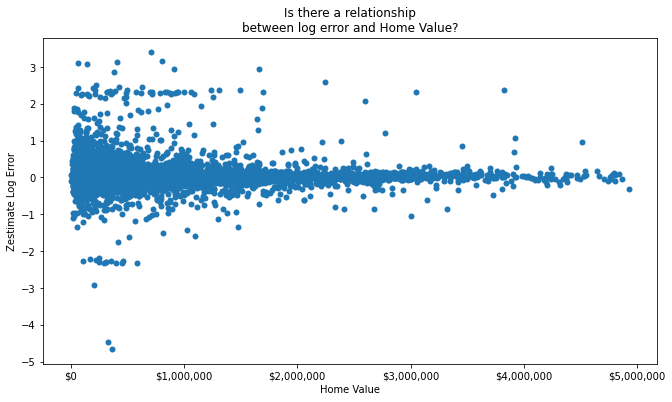

In [12]:
# Plot of log error vs home value
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="taxvaluedollarcnt", y="logerror",
                sizes=(1, 8), linewidth=0,
                data=train, ax=ax)
plt.title('Is there a relationship\nbetween log error and Home Value?')
plt.xlabel('Home Value')
plt.ylabel('Zestimate Log Error')
ax.xaxis.set_major_formatter('${:,.0f}'.format) 

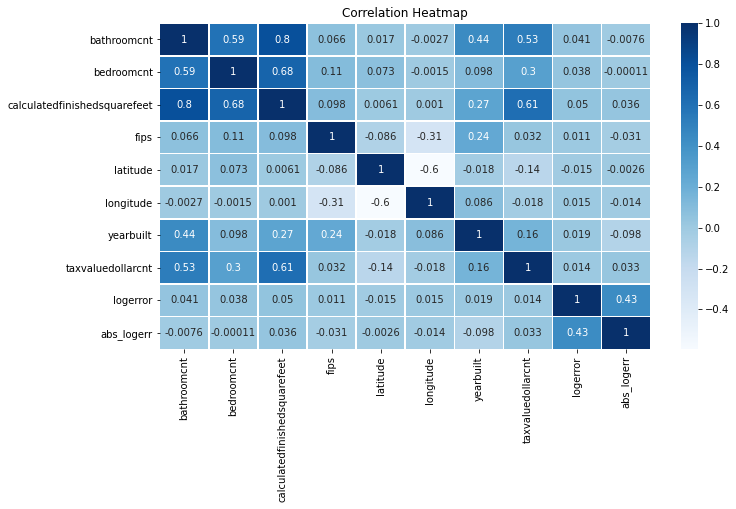

In [13]:
plt.figure(figsize=(11,6))
sns.heatmap(train.corr(), cmap='Blues', annot=True, linewidth=0.5)
plt.title('Correlation Heatmap')
plt.show()

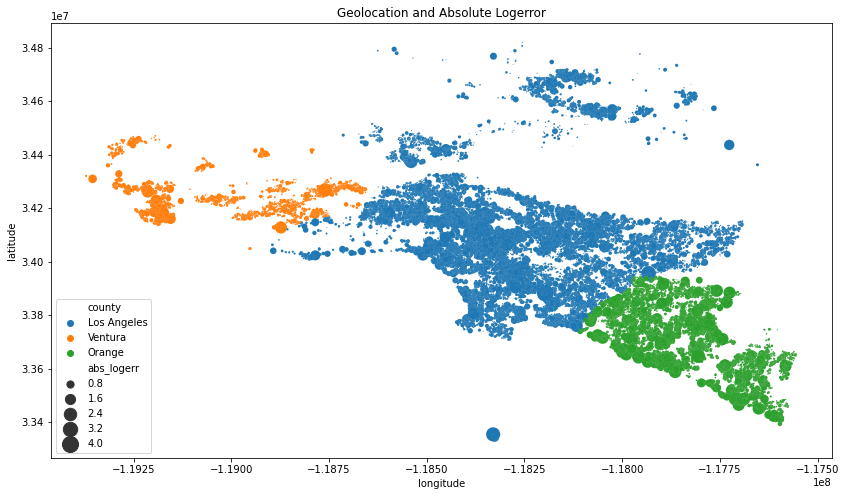

In [14]:
# Plot of error using lat/long
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue='county', size='abs_logerr', sizes=(0,300), data=train)
plt.legend()
plt.title('Geolocation and Absolute Logerror')
plt.show()

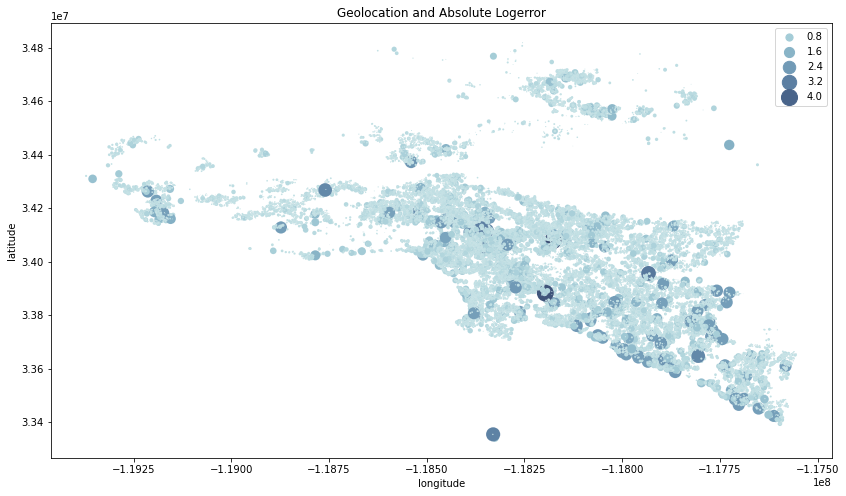

In [15]:
# Plot of error using lat/long
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue='abs_logerr', palette="ch:r=-.2,d=.3", size='abs_logerr', sizes=(0,300), data=train)
plt.legend()
plt.title('Geolocation and Absolute Logerror')
plt.show()

##### Takeaways:
- There seems to be bands of clusters in log error vs above categories
- Lat Long seems to be the most promising to explore via clustering
- Then potentially sqft and beadroom/bathroom count

### Statistics

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42546 entries, 28420 to 47816
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   42546 non-null  float64
 1   bedroomcnt                    42546 non-null  float64
 2   calculatedfinishedsquarefeet  42546 non-null  float64
 3   fips                          42546 non-null  float64
 4   latitude                      42546 non-null  float64
 5   longitude                     42546 non-null  float64
 6   yearbuilt                     42546 non-null  float64
 7   taxvaluedollarcnt             42546 non-null  float64
 8   logerror                      42546 non-null  float64
 9   transactiondate               42546 non-null  object 
 10  heatingorsystemdesc           42546 non-null  object 
 11  county                        42546 non-null  object 
 12  abs_logerr                    42546 non-null  float64
dt

### Scaling

In [17]:
# Scale the datasets
column = ['fips', 'transactiondate', 'heatingorsystemdesc', 'county', ]
scaler = sklearn.preprocessing.MinMaxScaler()
cols = train.drop(columns=column).columns.tolist()

# .copy() makes a proper copy
# this is an alternative to wrapping the scaled numpy array in a pd.Dataframe()
train_scaled = train.copy()
validate_scaled = validate.copy()
test_scaled = test.copy()

# apply our scaler (fit only on train!)
train_scaled[cols] = scaler.fit_transform(train[cols])
validate_scaled[cols] = scaler.transform(validate[cols])
test_scaled[cols] = scaler.transform(test[cols])

train_scaled = train_scaled.drop(columns=column)
validate_scaled = validate_scaled.drop(columns=column)
test_scaled = test_scaled.drop(columns=column)

In [18]:
train_scaled.head(2)

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  latitude  \
28420        0.125         0.1                      0.074901  0.573464   
66765        0.000         0.1                      0.147043  0.441294   

       longitude  yearbuilt  taxvaluedollarcnt  logerror  abs_logerr  
28420   0.502856   0.826087           0.028647  0.580490     0.00376  
66765   0.594425   0.224638           0.027425  0.585111     0.01175

## Initial Regression Models

In [19]:
X_train, y_train, X_validate, y_validate, X_test, y_test = zm.zillow_xy(train_scaled.drop(columns='abs_logerr'), 
                                                                        validate_scaled.drop(columns='abs_logerr'), 
                                                                        test_scaled.drop(columns='abs_logerr'))

In [20]:
compare = zm.model_compare(X_train, y_train, X_validate, y_validate)
compare

model  RMSE Train  RMSE Validate  r^2 Validate
0  Baseline (mean)     0.02051        0.02084      0.000000
1    OLS Regressor     0.02047        0.02084     -0.000075
2   Lasso: Alpha 1     0.02051        0.02084      0.000000
3       GLM Normal     0.02048        0.02084     -0.000168
4      GLM Poisson     0.02048        0.02084     -0.000306
5  Polynomial 2deg     0.02044        0.02083      0.000690
6  Polynomial 3deg     0.02038        0.02091     -0.006295

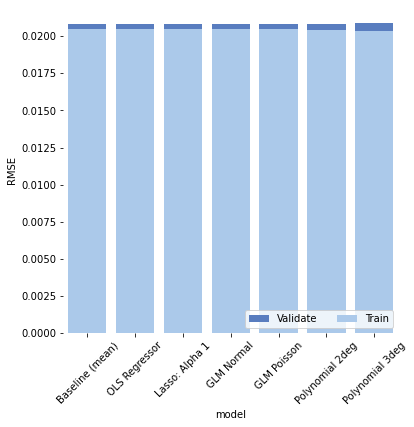

In [21]:
# Visual representation of the above chart:
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes("muted")
sns.barplot(x="model", y="RMSE Validate", data=compare,
            label="Validate", color="b")
sns.set_color_codes("pastel")
sns.barplot(x="model", y="RMSE Train", data=compare,
            label="Train", color="b")
ax.legend(ncol=2, loc="lower right", frameon=True)
plt.ylabel('RMSE')
plt.xticks(rotation = 45)
sns.despine(left=True, bottom=True)

In [22]:
#Recursive Feature Elimination Ranking
ee.rfe_output(X_train, y_train)

Var  Rank
0                   bathroomcnt     7
1                    bedroomcnt     4
2  calculatedfinishedsquarefeet     1
3                      latitude     3
4                     longitude     6
5                     yearbuilt     5
6             taxvaluedollarcnt     2

## Clustering: K-Means

#### Clustering by Latitude, Logitude and Absolute Error

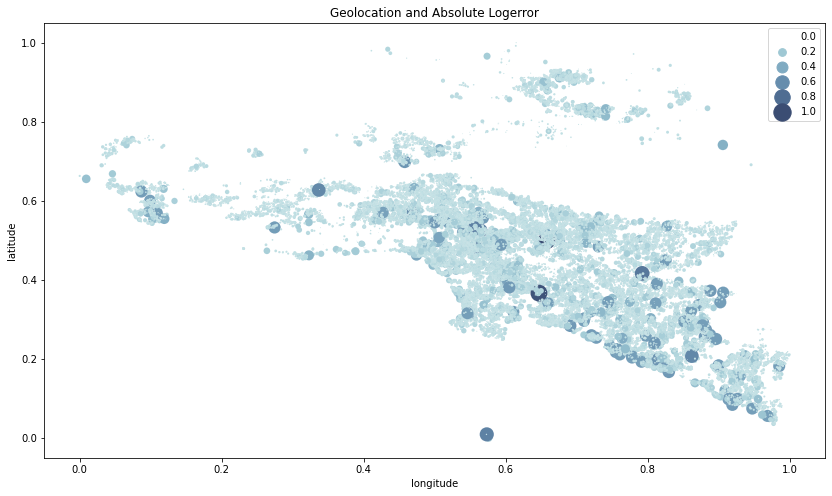

In [23]:
# Plot of error using lat/long
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue='abs_logerr', palette="ch:r=-.2,d=.3", size='abs_logerr', sizes=(0,300), data=train_scaled)
plt.legend()
plt.title('Geolocation and Absolute Logerror')
plt.show()

In [27]:
def find_k(X_train, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # compute the difference from one k to the next
    delta = [round(sse[i] - sse[i+1],0) for i in range(len(sse)-1)]

    # compute the percent difference from one k to the next
    pct_delta = [round(((sse[i] - sse[i+1])/sse[i])*100, 1) for i in range(len(sse)-1)]

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    # plot k with pct_delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.pct_delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Percent Change')
    plt.title('For which k values are we seeing increased changes (%) in SSE?')
    plt.show()

    # plot k with delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Absolute Change in SSE')
    plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
    plt.show()

    return k_comparisons_df

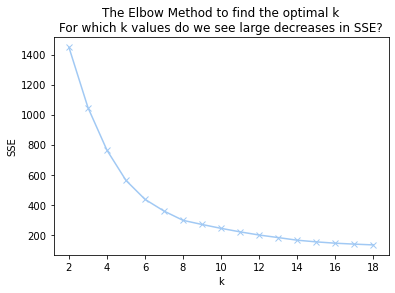

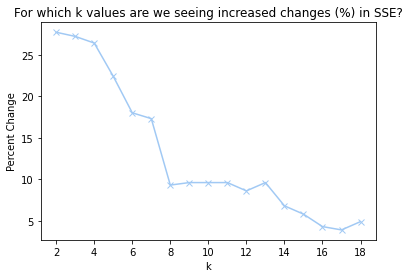

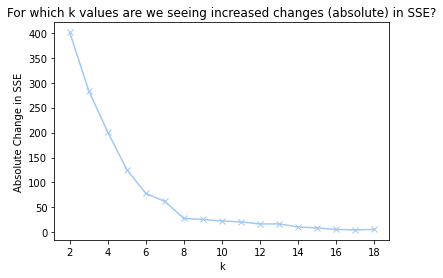

k          sse  delta  pct_delta
0    2  1448.745064  401.0       27.7
1    3  1047.309944  284.0       27.2
2    4   762.960353  201.0       26.4
3    5   561.736397  126.0       22.4
4    6   435.734116   78.0       18.0
5    7   357.504386   62.0       17.3
6    8   295.797988   28.0        9.3
7    9   268.222820   26.0        9.6
8   10   242.438105   23.0        9.6
9   11   219.063045   21.0        9.6
10  12   198.023047   17.0        8.6
11  13   181.051415   17.0        9.6
12  14   163.595499   11.0        6.8
13  15   152.440241    9.0        5.8
14  16   143.628482    6.0        4.3
15  17   137.470165    5.0        3.9
16  18   132.167984    6.0        4.9

In [28]:
cluster_vars = ['latitude', 'longitude', 'abs_logerr']
cluster_name = 'latlong_err_cluster'
k_range = range(2,20)

k_comparisons_df = find_k(train_scaled, cluster_vars, k_range)
k_comparisons_df

In [29]:
# Fit K-Means (just on train, again!)
X = train_scaled[['latitude', 'longitude', 'abs_logerr']]
kmeans = KMeans(n_clusters=8)
kmeans.fit(X)

train_scaled['latlong_err_cluster'] = kmeans.predict(X)
train_scaled.head()

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  latitude  \
28420        0.125         0.1                      0.074901  0.573464   
66765        0.000         0.1                      0.147043  0.441294   
25714        0.125         0.2                      0.096715  0.564669   
21340        0.125         0.3                      0.193824  0.626706   
46673        0.000         0.2                      0.101971  0.326450   

       longitude  yearbuilt  taxvaluedollarcnt  logerror  abs_logerr  \
28420   0.502856   0.826087           0.028647  0.580490    0.003760   
66765   0.594425   0.224638           0.027425  0.585111    0.011750   
25714   0.463232   0.688406           0.062036  0.577882    0.000749   
21340   0.377168   0.623188           0.052018  0.575085    0.005586   
46673   0.557556   0.543478           0.061563  0.588555    0.017706   

       latlong_err_cluster  
28420                    2  
66765                    0  
25714                    2  
21340                    2  
46673                    7

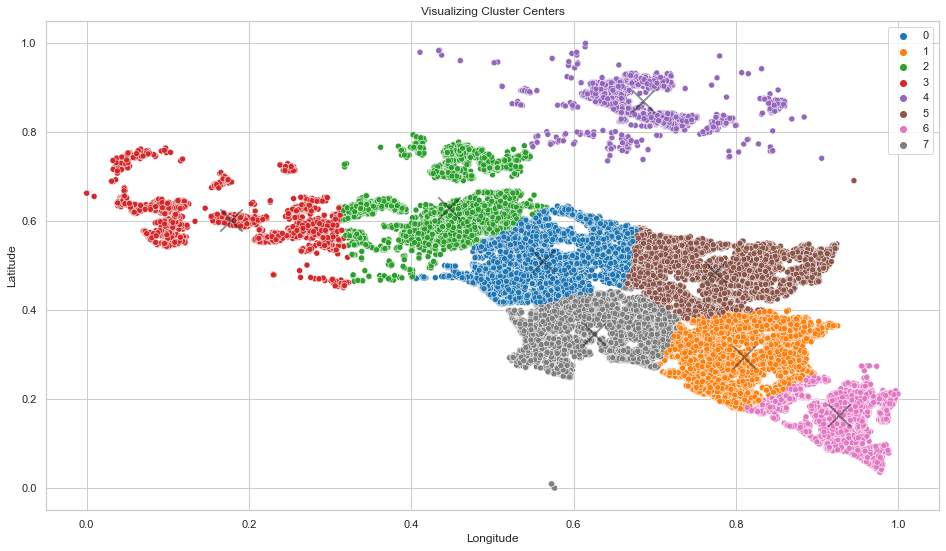

In [30]:
#Plot of clusters with centroids
centroid = train_scaled.groupby('latlong_err_cluster').mean()
centroid

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(16, 9))

sns.scatterplot(x='longitude', y='latitude',
                hue="latlong_err_cluster", 
                palette="tab10",
                data=train_scaled, ax=ax)

sns.scatterplot(x='longitude', y='latitude', 
                color='k', marker='x', s=500,
                data=centroid, ax=ax, alpha=.5)

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualizing Cluster Centers')
plt.show()

In [31]:
# Fit K-Means (just on train, again!)
X = train_scaled[['latitude', 'longitude', 'abs_logerr']]
kmeans = KMeans(n_clusters=200)
kmeans.fit(X)

train_scaled['latlong_err_cluster'] = kmeans.predict(X)
train_scaled.head()

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  latitude  \
28420        0.125         0.1                      0.074901  0.573464   
66765        0.000         0.1                      0.147043  0.441294   
25714        0.125         0.2                      0.096715  0.564669   
21340        0.125         0.3                      0.193824  0.626706   
46673        0.000         0.2                      0.101971  0.326450   

       longitude  yearbuilt  taxvaluedollarcnt  logerror  abs_logerr  \
28420   0.502856   0.826087           0.028647  0.580490    0.003760   
66765   0.594425   0.224638           0.027425  0.585111    0.011750   
25714   0.463232   0.688406           0.062036  0.577882    0.000749   
21340   0.377168   0.623188           0.052018  0.575085    0.005586   
46673   0.557556   0.543478           0.061563  0.588555    0.017706   

       latlong_err_cluster  
28420                    1  
66765                   92  
25714                   33  
21340                   87  
46673                   86

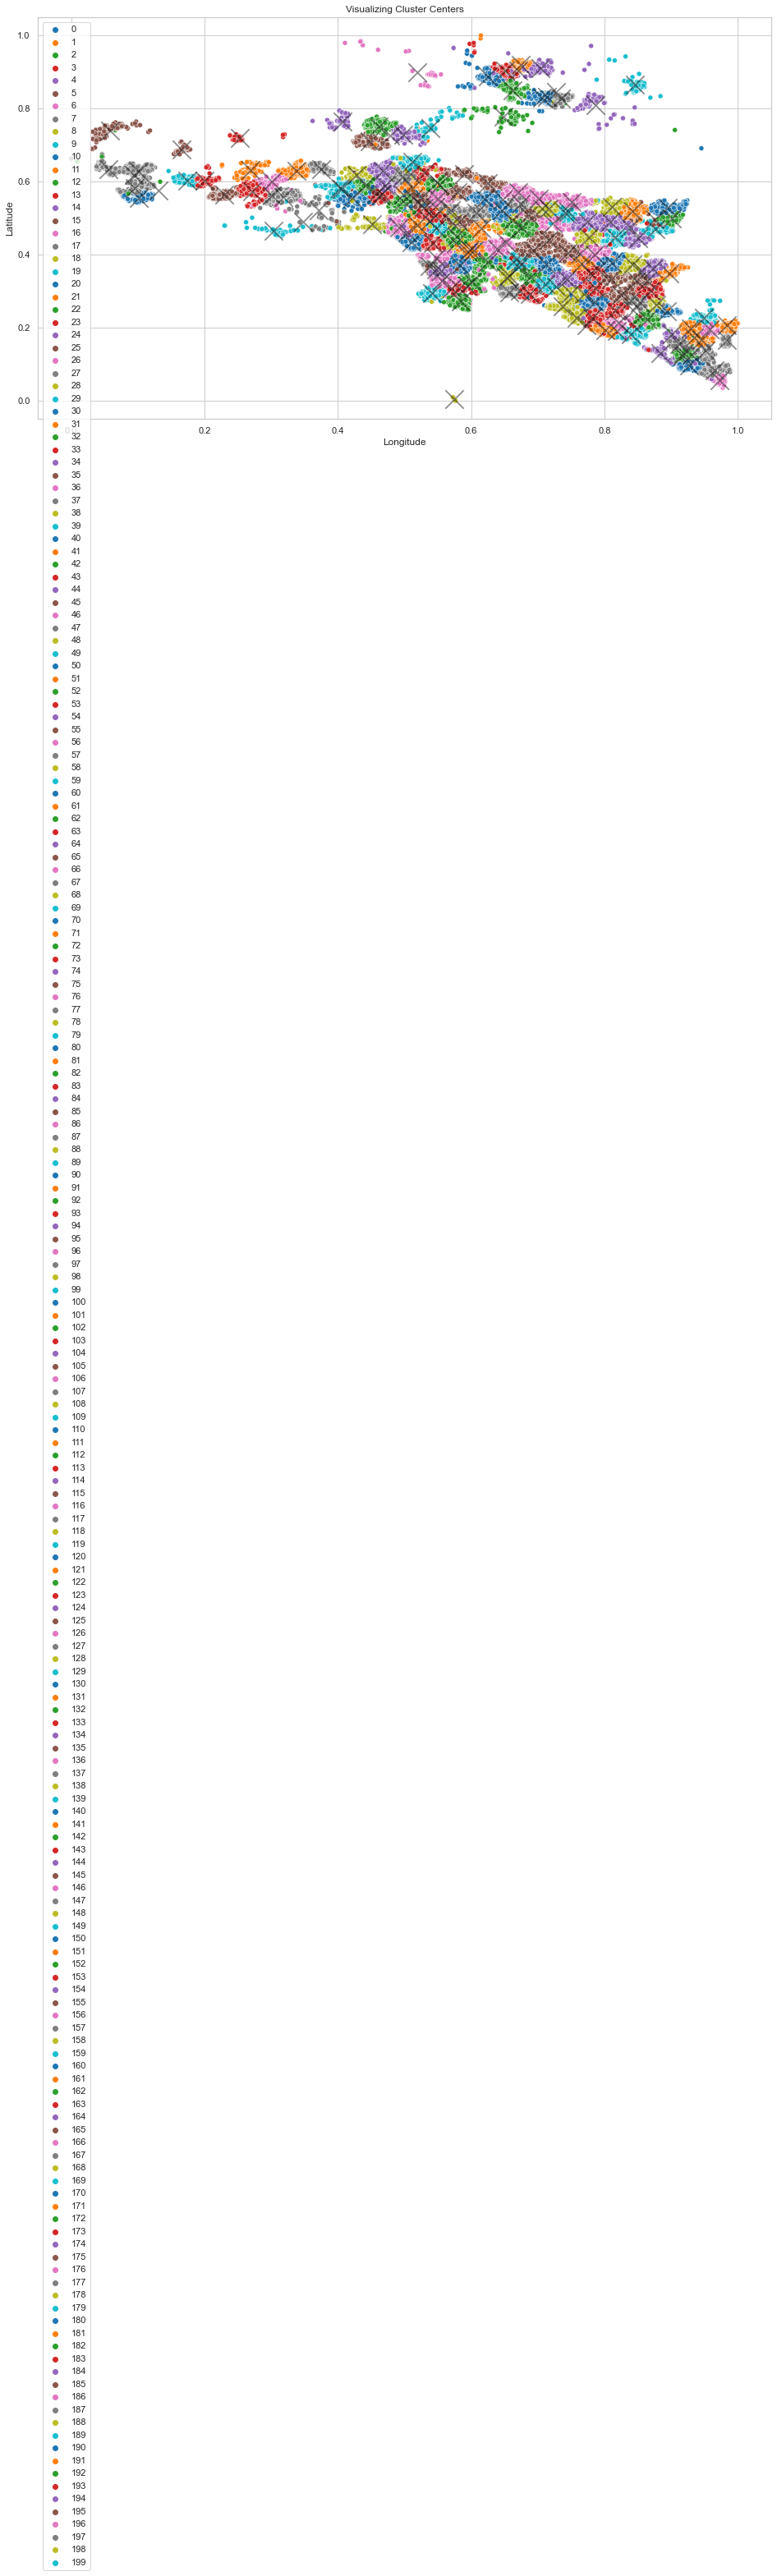

In [32]:
#Plot of clusters with centroids
centroid = train_scaled.groupby('latlong_err_cluster').mean()
centroid

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(16, 9))

sns.scatterplot(x='longitude', y='latitude',
                hue="latlong_err_cluster", 
                palette="tab10",
                data=train_scaled, ax=ax)

sns.scatterplot(x='longitude', y='latitude', 
                color='k', marker='x', s=500,
                data=centroid, ax=ax, alpha=.5)

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualizing Cluster Centers')
plt.show()

In [33]:
# Fit K-Means (just on train, again!)
X = train_scaled[['latitude', 'longitude', 'abs_logerr']]
kmeans = KMeans(n_clusters=1000)
kmeans.fit(X)

train_scaled['latlong_err_cluster'] = kmeans.predict(X)
train_scaled.head()

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  latitude  \
28420        0.125         0.1                      0.074901  0.573464   
66765        0.000         0.1                      0.147043  0.441294   
25714        0.125         0.2                      0.096715  0.564669   
21340        0.125         0.3                      0.193824  0.626706   
46673        0.000         0.2                      0.101971  0.326450   

       longitude  yearbuilt  taxvaluedollarcnt  logerror  abs_logerr  \
28420   0.502856   0.826087           0.028647  0.580490    0.003760   
66765   0.594425   0.224638           0.027425  0.585111    0.011750   
25714   0.463232   0.688406           0.062036  0.577882    0.000749   
21340   0.377168   0.623188           0.052018  0.575085    0.005586   
46673   0.557556   0.543478           0.061563  0.588555    0.017706   

       latlong_err_cluster  
28420                  573  
66765                  880  
25714                  969  
21340                  231  
46673                  795

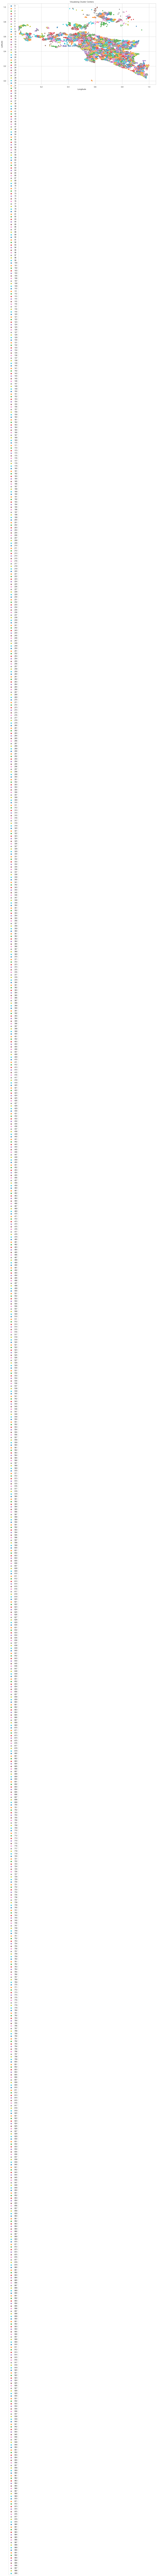

In [39]:
#Plot of clusters with centroids
centroid = train_scaled.groupby('latlong_err_cluster').mean()
centroid

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(16, 9))

sns.scatterplot(x='longitude', y='latitude',
                hue="latlong_err_cluster",
                palette="tab10", 
                data=train_scaled, ax=ax)

# sns.scatterplot(x='longitude', y='latitude', 
#                 color='k', marker='x', s=500,
#                 data=centroid, ax=ax, alpha=.5)

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualizing Cluster Centers')
plt.show()

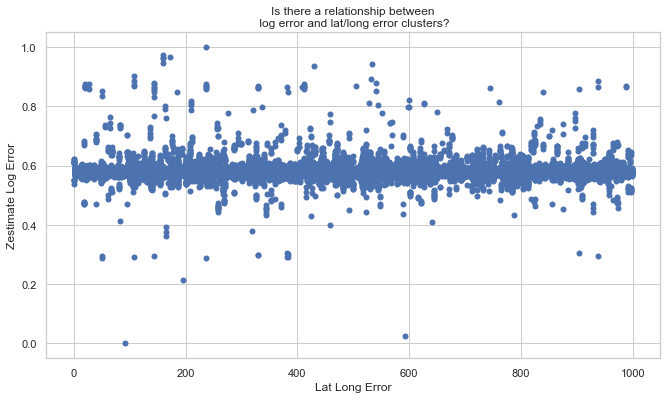

In [51]:
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="latlong_err_cluster", y="logerror",
                sizes=(1, 8), linewidth=0,
                data=train_scaled, ax=ax)
plt.title('Is there a relationship between\n log error and lat/long error clusters?')
plt.xlabel('Lat Long Error')
plt.ylabel('Zestimate Log Error')
ax.xaxis.set_major_formatter('{:.0f}'.format)
plt.show()

#### Cluster by Home Value and Size (Square Feet)

In [34]:
train_scaled.head(3)

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  latitude  \
28420        0.125         0.1                      0.074901  0.573464   
66765        0.000         0.1                      0.147043  0.441294   
25714        0.125         0.2                      0.096715  0.564669   

       longitude  yearbuilt  taxvaluedollarcnt  logerror  abs_logerr  \
28420   0.502856   0.826087           0.028647  0.580490    0.003760   
66765   0.594425   0.224638           0.027425  0.585111    0.011750   
25714   0.463232   0.688406           0.062036  0.577882    0.000749   

       latlong_err_cluster  
28420                  573  
66765                  880  
25714                  969

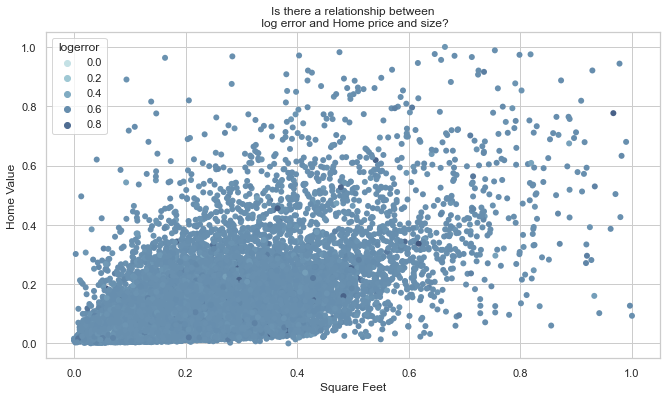

In [50]:
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="calculatedfinishedsquarefeet", y="taxvaluedollarcnt", hue='logerror',
                palette="ch:r=-.2,d=.3", sizes=(1, 8), linewidth=0,
                data=train_scaled, ax=ax)
plt.title('Is there a relationship between\n log error and Home price and size?')
plt.xlabel('Square Feet')
plt.ylabel('Home Value')
ax.xaxis.set_major_formatter('{:.1f}'.format)
plt.show()

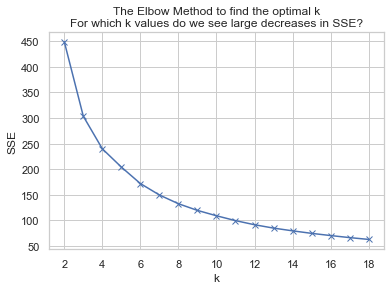

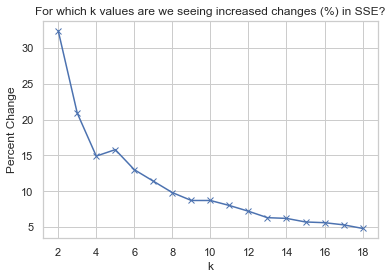

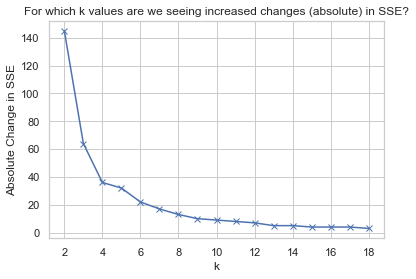

k         sse  delta  pct_delta
0    2  448.800224  145.0       32.4
1    3  303.374204   64.0       20.9
2    4  239.847081   36.0       14.9
3    5  204.202043   32.0       15.8
4    6  172.033171   22.0       13.0
5    7  149.750080   17.0       11.4
6    8  132.658955   13.0        9.8
7    9  119.643401   10.0        8.7
8   10  109.175067    9.0        8.7
9   11   99.701086    8.0        8.0
10  12   91.675271    7.0        7.2
11  13   85.096229    5.0        6.3
12  14   79.773002    5.0        6.2
13  15   74.849253    4.0        5.7
14  16   70.550649    4.0        5.6
15  17   66.564864    4.0        5.3
16  18   63.022955    3.0        4.8

In [52]:
cluster_vars = ['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']
cluster_name = 'size_value'
k_range = range(2,20)

k_comparisons_df = find_k(train_scaled, cluster_vars, k_range)
k_comparisons_df

In [57]:
# Fit K-Means (just on train, again!)
X = train_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

train_scaled['home_size_value'] = kmeans.predict(X)
train_scaled.head(2)

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  latitude  \
28420        0.125         0.1                      0.074901  0.573464   
66765        0.000         0.1                      0.147043  0.441294   

       longitude  yearbuilt  taxvaluedollarcnt  logerror  abs_logerr  \
28420   0.502856   0.826087           0.028647  0.580490     0.00376   
66765   0.594425   0.224638           0.027425  0.585111     0.01175   

       latlong_err_cluster  home_size_value  
28420                  573                4  
66765                  880                4

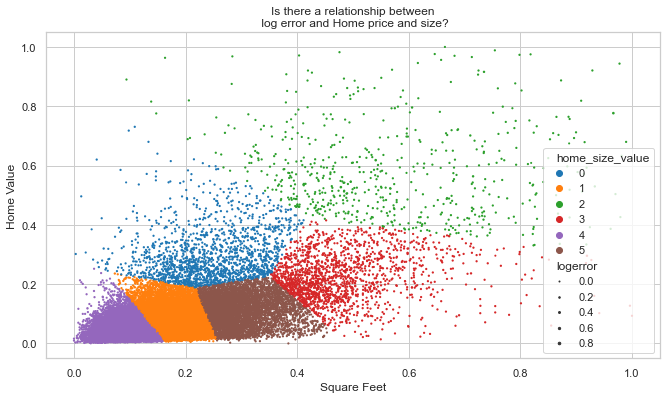

In [67]:
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="calculatedfinishedsquarefeet", y="taxvaluedollarcnt", hue='home_size_value', size='logerror',
                palette="tab10", sizes=(1, 8), linewidth=0,
                data=train_scaled, ax=ax)
plt.title('Is there a relationship between\n log error and Home price and size?')
plt.xlabel('Square Feet')
plt.ylabel('Home Value')
ax.xaxis.set_major_formatter('{:.1f}'.format)
plt.show()

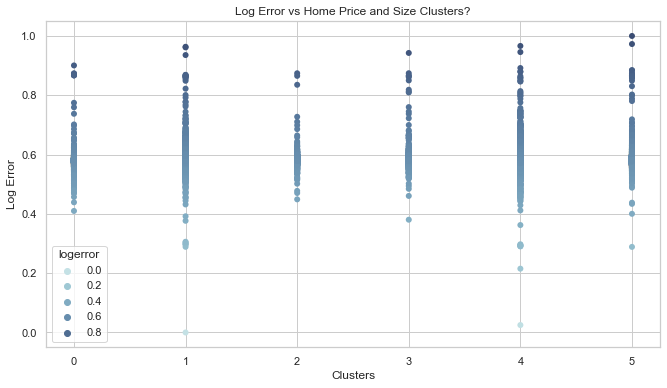

In [61]:
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="home_size_value", y="logerror", hue='logerror',
                palette="ch:r=-.2,d=.3", sizes=(1, 8), linewidth=0,
                data=train_scaled, ax=ax)
plt.title('Log Error vs Home Price and Size Clusters?')
plt.xlabel('Clusters')
plt.ylabel('Log Error')
ax.xaxis.set_major_formatter('{:.0f}'.format)
plt.show()

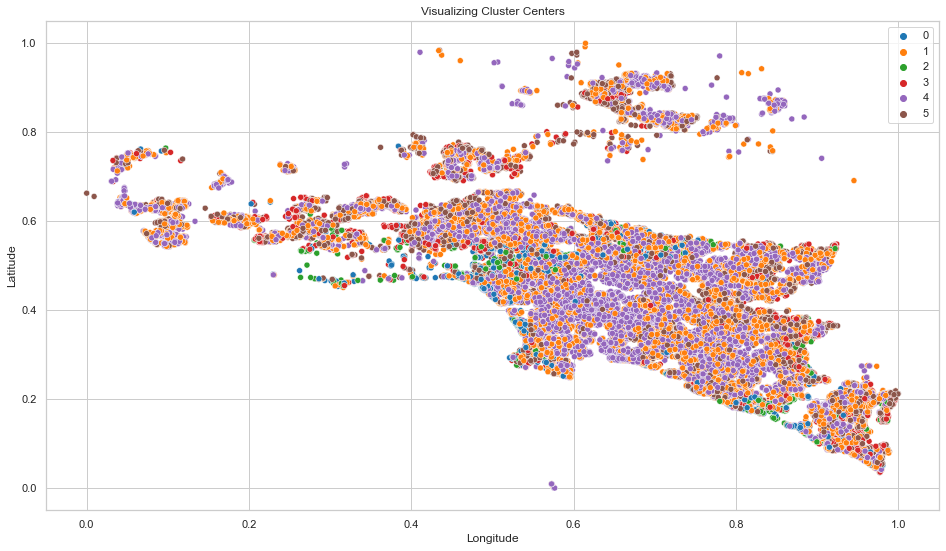

In [68]:
#Plot of clusters with centroids
centroid = train_scaled.groupby('home_size_value').mean()
centroid

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(16, 9))

sns.scatterplot(x='longitude', y='latitude',
                hue="home_size_value",
                palette="tab10", 
                data=train_scaled, ax=ax)

# sns.scatterplot(x='longitude', y='latitude', 
#                 color='k', marker='x', s=500,
#                 data=centroid, ax=ax, alpha=.5)

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualizing Cluster Centers')
plt.show()

## Linear Regression Modeling with Clusters